Shape: (303, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1



Target distribution:


,proportion
target,
1,0.544554
0,0.455446



Missing values per column:


,missing_count
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0



Numeric features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

Train size: (242, 13) Test size: (61, 13)

Fitting Logistic Regression (CV tuning)...
Best LR params: {'model__C': 0.5, 'model__penalty': 'l2'}
Best LR CV ROC-AUC: 0.8965

Fitting Random Forest (CV tuning)...
Best RF params: {'model__max_depth': 6, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 500}
Best RF CV ROC-AUC: 0.8995

Holdout Test Performance (higher is better for ROC-AUC):


,Accuracy,Precision,Recall,F1,ROC-AUC
Model,,,,,
Logistic Regression (tuned),0.885246,0.861111,0.939394,0.898551,0.910173
Random Forest (tuned),0.770492,0.731707,0.909091,0.810811,0.902597



Confusion Matrix — Logistic Regression:
 [[23  5]
 [ 2 31]]

Confusion Matrix — Random Forest:
 [[17 11]
 [ 3 30]]

Classification report — Logistic Regression:
              precision    recall  f1-score   support

           0      0.920     0.821     0.868        28
           1      0.861     0.939     0.899        33

    accuracy                          0.885        61
   macro avg      0.891     0.880     0.883        61
weighted avg      0.888     0.885     0.884        61


Classification report — Random Forest:
              precision    recall  f1-score   support

           0      0.850     0.607     0.708        28
           1      0.732     0.909     0.811        33

    accuracy                          0.770        61
   macro avg      0.791     0.758     0.760        61
weighted avg      0.786     0.770     0.764        61


FINAL MODEL SELECTED: Logistic Regression (tuned)


<Figure size 640x480 with 0 Axes>

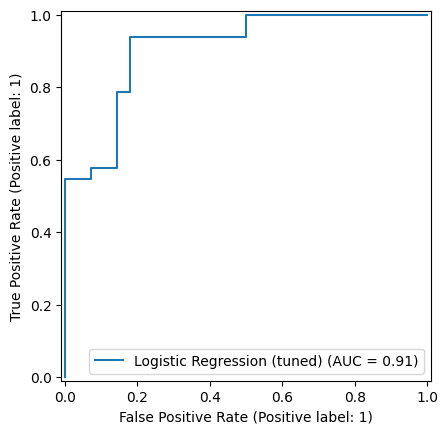

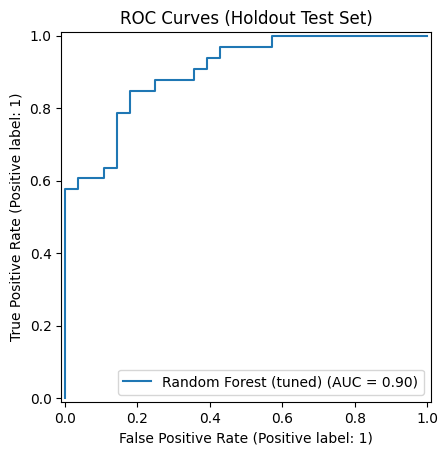

<Figure size 640x480 with 0 Axes>

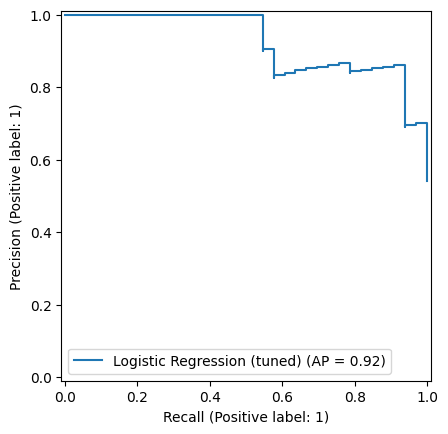

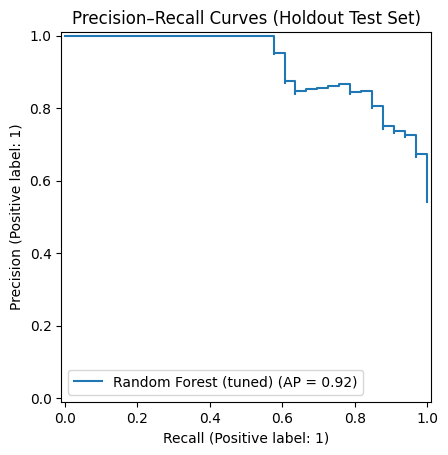


Top 15 coefficients by absolute value (Logistic Regression):


,feature,coef
7,cp_0,-1.043350
21,ca_0,0.935214
29,thal_3,-0.762226
28,thal_2,0.720133
23,ca_2,-0.616776
9,cp_2,0.595450
5,sex_0,0.518714
10,cp_3,0.502600
6,sex_1,-0.490532
2,chol,-0.461913


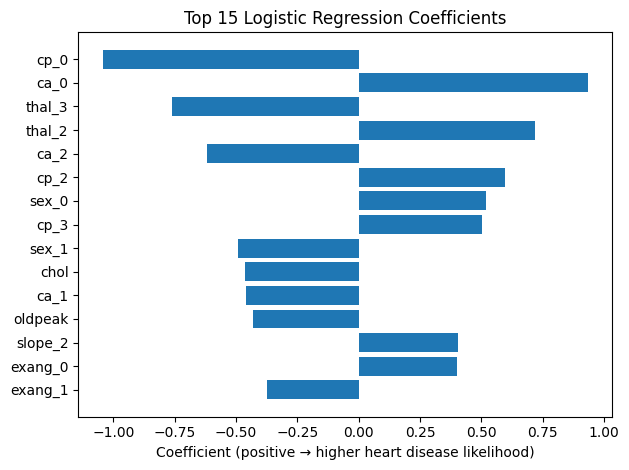


Run summary (copy into report notes if needed):
{'dataset_rows': 303, 'dataset_cols': 14, 'target_rate': 0.5445544554455446, 'best_lr_params': {'model__C': 0.5, 'model__penalty': 'l2'}, 'best_rf_params': {'model__max_depth': 6, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 500}, 'test_metrics': {'Logistic Regression (tuned)': {'Accuracy': 0.8852459016393442, 'Precision': 0.8611111111111112, 'Recall': 0.9393939393939394, 'F1': 0.8985507246376812, 'ROC-AUC': 0.9101731601731602}, 'Random Forest (tuned)': {'Accuracy': 0.7704918032786885, 'Precision': 0.7317073170731707, 'Recall': 0.9090909090909091, 'F1': 0.8108108108108109, 'ROC-AUC': 0.9025974025974026}}, 'final_model': 'Logistic Regression (tuned)'}

Done. Next: write-up section can reference the comparison table, ROC/PR curves, and feature importance.


In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -----------------------------
# 1) Load data
# -----------------------------
DATA_PATH = "/content/heart.csv"  # Colab default path after upload
if not os.path.exists(DATA_PATH):
    # fallback for this environment / or if you mounted another directory
    DATA_PATH = "/mnt/data/heart.csv"

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

# Basic sanity checks
assert "target" in df.columns, "Expected 'target' column not found."
print("\nTarget distribution:")
display(df["target"].value_counts(normalize=True).rename("proportion").to_frame())

print("\nMissing values per column:")
display(df.isna().sum().to_frame("missing_count"))

# -----------------------------
# 2) Define features & target
# -----------------------------
X = df.drop(columns=["target"])
y = df["target"].astype(int)

# In this dataset, many integer columns are actually categorical codes.
# Treating them as categorical improves interpretability and often performance.
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
numeric_features = [c for c in X.columns if c not in categorical_features]

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

# -----------------------------
# 3) Train-test split (stratified)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

print("\nTrain size:", X_train.shape, "Test size:", X_test.shape)

# -----------------------------
# 4) Preprocessing
# -----------------------------
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# -----------------------------
# 5) Model definitions
# -----------------------------
logreg = LogisticRegression(
    max_iter=5000,
    solver="liblinear",   # stable for small datasets
    random_state=RANDOM_STATE
)

rf = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe_lr = Pipeline(steps=[("preprocess", preprocess),
                         ("model", logreg)])

pipe_rf = Pipeline(steps=[("preprocess", preprocess),
                         ("model", rf)])

# -----------------------------
# 6) Cross-validated model tuning (on TRAIN only)
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid_lr = {
    "model__C": [0.1, 0.5, 1.0, 2.0, 5.0],
    "model__penalty": ["l1", "l2"]
}

param_grid_rf = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 4, 6, 10],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid_lr,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True
)

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True
)

print("\nFitting Logistic Regression (CV tuning)...")
grid_lr.fit(X_train, y_train)
print("Best LR params:", grid_lr.best_params_)
print("Best LR CV ROC-AUC:", round(grid_lr.best_score_, 4))

print("\nFitting Random Forest (CV tuning)...")
grid_rf.fit(X_train, y_train)
print("Best RF params:", grid_rf.best_params_)
print("Best RF CV ROC-AUC:", round(grid_rf.best_score_, 4))

# -----------------------------
# 7) Evaluation helpers
# -----------------------------
def evaluate_binary_classifier(name, model, X_te, y_te, threshold=0.50):
    """Evaluate a fitted classifier on a holdout set."""
    proba = model.predict_proba(X_te)[:, 1]
    pred = (proba >= threshold).astype(int)

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_te, pred),
        "Precision": precision_score(y_te, pred, zero_division=0),
        "Recall": recall_score(y_te, pred, zero_division=0),
        "F1": f1_score(y_te, pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_te, proba)
    }

    cm = confusion_matrix(y_te, pred)
    return metrics, cm, proba, pred

# Evaluate both tuned models on TEST set
lr_metrics, lr_cm, lr_proba, lr_pred = evaluate_binary_classifier(
    "Logistic Regression (tuned)", grid_lr.best_estimator_, X_test, y_test
)

rf_metrics, rf_cm, rf_proba, rf_pred = evaluate_binary_classifier(
    "Random Forest (tuned)", grid_rf.best_estimator_, X_test, y_test
)

results = pd.DataFrame([lr_metrics, rf_metrics]).set_index("Model").sort_values("ROC-AUC", ascending=False)
print("\nHoldout Test Performance (higher is better for ROC-AUC):")
display(results)

print("\nConfusion Matrix — Logistic Regression:\n", lr_cm)
print("\nConfusion Matrix — Random Forest:\n", rf_cm)

print("\nClassification report — Logistic Regression:")
print(classification_report(y_test, lr_pred, digits=3))

print("\nClassification report — Random Forest:")
print(classification_report(y_test, rf_pred, digits=3))

# -----------------------------
# 8) Choose final model
# -----------------------------
# Simple rule: choose higher ROC-AUC; if close, prefer higher Recall for medical screening.
final_model = grid_rf.best_estimator_ if results.index[0].startswith("Random Forest") else grid_lr.best_estimator_
final_name = results.index[0]

print("\nFINAL MODEL SELECTED:", final_name)

# -----------------------------
# 9) Plots: ROC + Precision-Recall
# -----------------------------
plt.figure()
RocCurveDisplay.from_estimator(grid_lr.best_estimator_, X_test, y_test, name="Logistic Regression (tuned)")
RocCurveDisplay.from_estimator(grid_rf.best_estimator_, X_test, y_test, name="Random Forest (tuned)")
plt.title("ROC Curves (Holdout Test Set)")
plt.show()

plt.figure()
PrecisionRecallDisplay.from_estimator(grid_lr.best_estimator_, X_test, y_test, name="Logistic Regression (tuned)")
PrecisionRecallDisplay.from_estimator(grid_rf.best_estimator_, X_test, y_test, name="Random Forest (tuned)")
plt.title("Precision–Recall Curves (Holdout Test Set)")
plt.show()

# -----------------------------
# 10) Feature importance (for Random Forest) OR coefficients (for Logistic Regression)
# -----------------------------
def get_feature_names(preprocessor):
    """Recover human-readable feature names after ColumnTransformer."""
    num_names = numeric_features
    cat_encoder = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_names = cat_encoder.get_feature_names_out(categorical_features).tolist()
    return num_names + cat_names

# Identify if the final model is RF or LR
model_step = final_model.named_steps["model"]
feature_names = get_feature_names(final_model.named_steps["preprocess"])

if isinstance(model_step, RandomForestClassifier):
    importances = model_step.feature_importances_
    fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)

    print("\nTop 15 feature importances (Random Forest):")
    display(fi.head(15))

    plt.figure()
    top = fi.head(15).iloc[::-1]
    plt.barh(top["feature"], top["importance"])
    plt.title("Top 15 Feature Importances (Random Forest)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

elif isinstance(model_step, LogisticRegression):
    # Coefficients after one-hot; positive means higher risk (for target=1)
    coefs = model_step.coef_.ravel()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False)

    print("\nTop 15 coefficients by absolute value (Logistic Regression):")
    display(coef_df.head(15)[["feature", "coef"]])

    plt.figure()
    top = coef_df.head(15).iloc[::-1]
    plt.barh(top["feature"], top["coef"])
    plt.title("Top 15 Logistic Regression Coefficients")
    plt.xlabel("Coefficient (positive → higher heart disease likelihood)")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 11) Small "analysis-ready" summary objects
# -----------------------------
# These are useful when you write your report:
summary = {
    "dataset_rows": int(df.shape[0]),
    "dataset_cols": int(df.shape[1]),
    "target_rate": float(df["target"].mean()),
    "best_lr_params": grid_lr.best_params_,
    "best_rf_params": grid_rf.best_params_,
    "test_metrics": results.to_dict(orient="index"),
    "final_model": final_name
}

print("\nRun summary (copy into report notes if needed):")
print(summary)

# -----------------------------
# 12) Save artifacts (optional for GitHub reproducibility)
# -----------------------------
# You can save results/figures in your repo.
# results.to_csv("model_comparison_test_metrics.csv", index=True)

print("\nDone. Next: write-up section can reference the comparison table, ROC/PR curves, and feature importance.")
